In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import random

from konlpy.tag import Mecab
from tqdm.notebook import tqdm

### 1. 데이터 읽어오기

In [2]:
# 데이터 읽어오기
chatbot_file_path = "ChatbotData.csv"

data = pd.read_csv(chatbot_file_path)

In [3]:
print(data.head())

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


### 2. 데이터 정제

In [4]:
# 문장 단위 텍스트 전처리
def preprocess_sentence(sentence):
    # 소문자 변환
    sentence = sentence.lower()

    # 알파벳, 한글, 숫자, 문장부호를 제외한 모든 문자를 삭제
    sentence = re.sub("[^a-zA-Z0-9가-힣.?!,]", "", sentence)

    return sentence

In [5]:
# 데이터셋 단위 전처리
def preprocess_data(data):
    questions = []
    answers = []
    for q, a in zip(data['Q'], data['A']):
        questions.append(preprocess_sentence(q))
        answers.append(preprocess_sentence(a))

    return questions, answers

### 3. 데이터 토큰화

In [6]:
# 형태소 분석기로 Mecab 이용
mecab = Mecab()

In [7]:
# 말뭉치 생성 함수
def build_corpus(df, tokenizer, max_token_length=50):
    # 중복 제거
    tmp = df.copy()
    print(f'데이터 크기 (원본): {len(tmp)}')
    tmp.drop_duplicates(subset=['Q'], inplace=True)
    print(f'데이터 크기 (Q 중복 제거 후): {len(tmp)}')
    #tmp.drop_duplicates(subset=['A'], inplace=True)
    #print(f'데이터 크기 (A 중복 제거 후): {len(tmp)}')

    # 전처리
    questions, answers = preprocess_data(tmp)

    # 토큰화, 필터링
    que_corpus = []
    ans_corpus = []
    for q, a in zip(questions, answers):
        q_tokens = tokenizer.morphs(q)
        a_tokens = tokenizer.morphs(a)
        if len(q_tokens) < max_token_length and len(a_tokens) < max_token_length:
            que_corpus.append(q_tokens)
            ans_corpus.append(a_tokens)
        else:
            print(f'토큰 길이 초과 문장: {q}, {a}')

    print(f'질문 말뭉치 크기: {len(que_corpus)}, 대답 말뭉치 크기: {len(ans_corpus)} ')
    return que_corpus, ans_corpus

#### 디버깅
- build_corpus 구현이 노드에서 정의한 사양과 다름
- 노드: 전처리 -> 토큰화 -> 필터링 -> 중복제거 순서로 처리, 소스 문장 데이터, 타겟 문장 데이터, 토크나이저를 입력으로 받음
- 구현: 중복제거 -> 전처리 -> 토큰화 -> 필터링 순서로 처리 (중복제거를 제일 먼저 함), 소스 문장, 타겟 문장이 하나로 묶인 DataFrame을 입력으로 받음

In [8]:
# 말뭉치 생성
que_corpus, ans_corpus = build_corpus(data, mecab, 50)

데이터 크기 (원본): 11823
데이터 크기 (Q 중복 제거 후): 11662
질문 말뭉치 크기: 11662, 대답 말뭉치 크기: 11662 


#### 디버깅
- 대답에 대해서도 중복 제거를 하면 데이터 크기가 크게 줄어듬 ==> **대답에 대해서는 중복 제거를 하지 않음**
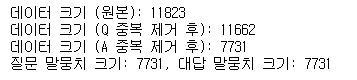
- 토큰 길이를 50으로 제한했으나, 50을 초과하는 문장은 없음

### 4. Augmentation

In [9]:
# 미리 학습된 Word2Vec 모델을 불러옴
from gensim.models import Word2Vec

pretrained_word2vec_file_path = "ko.bin"

word2vec_model = Word2Vec.load(pretrained_word2vec_file_path)

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

#### 디버깅
- 미리 학습된 word2vec 모델을 로드할 때, 아래와 같은 에러가 발생함
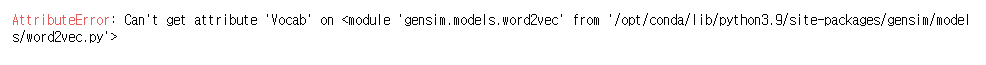
- 인터넷 검색을 통해 gensim의 버전 문제임을 확인
- 버전을 3.8.3, 3.8.1 로 다운그레이드 했으나, 여전히 문제가 발생함
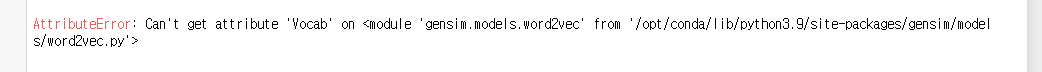

- **오픈소스 생태계가 성공하지 못하는 이유 중에 하나가 라이브러리 하위 호환성 유지 문제라고 생각함**

In [10]:
# 설치된 gensim 버전 확인
!pip list | grep gensim

gensim                        4.1.2


In [11]:
# gensim 다운그레이드
#!pip install --upgrade gensim==3.8.3

- **미리 학습된 Word2Vec 모델을 불러오지 못하는 이슈를 해결하지 못해서, augmentation 과정 생략**

### 5. 데이터 벡터화

In [12]:
# 미리 정의된 word index
PAD_INDEX = 0
START_INDEX = 1
END_INDEX = 2
UNKNOWN_INDEX = 3

In [15]:
# 벡터화 함수 - 패딩도 추가됨
def vectorize(question_corpus, answer_corpus):
    # 시작/종료 토큰 추가
    print(f'질문: {len(question_corpus)}, 대답: {len(answer_corpus)}')
    answer_corpus = [["<start>"] + answer + ["<end>"] for answer in answer_corpus]

    # 결합
    corpus =  question_corpus + answer_corpus
    print(f'전체: {len(corpus)}')

    # 사전 생성
    word_to_index = {}
    word_to_index["<pad>"] = PAD_INDEX
    word_to_index["<start>"] = START_INDEX
    word_to_index["<end>"] = END_INDEX
    word_to_index["<unknown>"] = UNKNOWN_INDEX

    word_index = 4
    for sentence in corpus:
        for word in sentence:
            if not word in word_to_index:
                word_to_index[word] = word_index
                word_index += 1
    index_to_word = {v:k for k,v in word_to_index.items()}
    print(f'사전 크기: {len(word_to_index)}, {len(index_to_word)}')

    # 벡터화
    question_vector = []
    answer_vector = []
    for question in question_corpus:
        vector = [word_to_index[word] for word in question]
        question_vector.append(vector)
    for answer in answer_corpus:
        vector = [word_to_index[word] for word in answer]
        answer_vector.append(vector)

    # 패딩 처리
    enc_train = tf.keras.preprocessing.sequence.pad_sequences(question_vector, padding='post')
    dec_train = tf.keras.preprocessing.sequence.pad_sequences(answer_vector, padding='post')

    return enc_train, dec_train, word_to_index, index_to_word

In [16]:
# 말뭉치에 대해 벡터화 수행
enc_train, dec_train, word_to_index, index_to_word = vectorize(que_corpus, ans_corpus)

질문: 11662, 대답: 11662
전체: 23324
사전 크기: 7145, 7145


In [17]:
print(enc_train.shape, dec_train.shape)

(11662, 31) (11662, 42)


In [19]:
VOCAB_SIZE = len(word_to_index)

### 6. 훈련하기
- Transformer 모델은 Node 17의 모델 참조

In [20]:
# 포지셔널 인코딩
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [21]:
# 패딩 마스크 생성
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [22]:
# 룩어헤드 마스크 생성
def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [23]:
# 마스크 생성 함수
def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [24]:
# 멀티헤드어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [25]:
# Position-wise Feed Forward Network
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [26]:
# 인코더 레이어
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [27]:
# 디코더 레이어
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual

        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [28]:
# 인코더
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [29]:
# 디코더
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [30]:
# 트랜스포머
class Transformer(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout=0.2, shared_fc=True, shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc:
            out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out
        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [33]:
# 모델 인스턴스 생성
transformer = Transformer(n_layers=2, d_model=512, n_heads=8, d_ff=2048, src_vocab_size=VOCAB_SIZE, tgt_vocab_size=VOCAB_SIZE, pos_len=200, dropout=0.3, shared_fc=True, shared_emb=True)

d_model = 512

In [34]:
# Learning Rate Scheduler
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [35]:
# 옵티마이저
learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [36]:
# Loss Function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [37]:
# Train Step
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [38]:
# 훈련

EPOCHS = 3
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE], dec_train[idx:idx+BATCH_SIZE], transformer, optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

In [39]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, square=True, vmin=0.0, vmax=1.0, cbar=False, ax=ax, xticklabels=x, yticklabels=y)

    #print(enc_attns.shape, dec_attns.shape, dec_enc_attns.shape)
    for layer in range(1):
        fig, axs = plt.subplots(1, 4, figsize=(16, 6))
        print("Encoder Layer", layer + 1)
        for h in range(1):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(1):
        fig, axs = plt.subplots(1, 4, figsize=(16, 6))
        print("Decoder Self Layer", layer+1)
        for h in range(1):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(16, 6))
        for h in range(1):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()


In [40]:
# index를 스트링으로 변환
def index_to_string(vector, index_to_word):
    res = ""
    for index in vector:
        if index in index_to_word:
            res += index_to_word[index] + " "
        else:
            res += "<ERROR> "

    return res

In [41]:
# 대답 생성 함수
def evaluate(sentence, model, tokenizer, word_to_index, index_to_word):
    # 전처리
    sentence = preprocess_sentence(sentence)

    # 토큰화
    tokens = tokenizer.morphs(sentence)
    
    # 벡터화
    vectors = [word_to_index[word] if word in word_to_index else UNKNOWN_INDEX for word in tokens]

    _input = tf.keras.preprocessing.sequence.pad_sequences([vectors], maxlen=enc_train.shape[-1], padding='post')
    
    ids = []
    output = tf.expand_dims([START_INDEX], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if END_INDEX == predicted_id:
            #result = tgt_tokenizer.decode_ids(ids)
            result = index_to_string(ids, index_to_word)
            return vectors, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = index_to_string(ids, index_to_word)

    return vectors, result, enc_attns, dec_attns, dec_enc_attns


In [42]:
# 질문하고 대답을 얻어오는 함수
def query(sentence):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, transformer, mecab, word_to_index, index_to_word)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    #if plot_attention:
    #    visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [43]:
query("오늘 날씨 어때?")

Input: 오늘 날씨 어때?
Predicted translation: 저 도 좋 은 생각 해 보 세요 . 
